# Сегментация тетрадей

## Detectron2 baseline

В данном ноутбуке представлен baseline модели сегментации текста в школьных тетрадях с помощью фреймворка detectron2. 

# 0. Установка библиотек

In [ ]:
!python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install tensorflow==2.1.0
!pip install -q albumentations==0.4.6

In [ ]:
!pip install -q albumentations==0.4.6

In [ ]:
!python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

## 1. Загрузить необходимые библиотеки для создания и обучения модели

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import random
import json
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import shutil
import numpy as np
import tqdm
from matplotlib import pyplot as plt

In [ ]:
import torch, torchvision
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog,DatasetCatalog
from detectron2.data.datasets import register_coco_instances,load_coco_json
from detectron2.data import detection_utils as utils
from detectron2.engine import DefaultTrainer
from detectron2.engine import HookBase

# from detectron2.utils.logger import setup_logger
# setup_logger()

import logging
logger = logging.getLogger('detectron2')
logger.setLevel(logging.CRITICAL)

Прежде чем переходить к загрузке данных посмотрим, доступны ли нам GPU-мощности. 

In [ ]:
print('GPU: ' + str(torch.cuda.is_available()))

GPU: True


# 2. Валидационный датасет

Для валидации наших моделей нам неплохо было создать из обучающих данных валидационный датасет. Для этого разделим наш датасет на две части - для обучения и для валидации. Для этого просто создадим два новых файлика с аннотациями, куда раздельно запишем исиходную информацию об аннотациях.

In [ ]:
import zipfile
!mkdir data
with zipfile.ZipFile('train.zip') as zf: 
    zf.extractall('data')

In [ ]:
import json
#Подгрузим аннотации train
with open('data/train/annotations.json') as f:
    annotations = json.load(f)

In [ ]:
print('Харьков')

In [ ]:
#Пустой словарь для аннотаций валидации
annotations_val = {}
#Список категорий такой же как в train
annotations_val['categories'] = annotations['categories']

#Пустой словарь для аннотаций нового train
annotations_train = {}
#Список категорий такой же как в train
annotations_train['categories'] = annotations['categories']


#Положим в валидацию каждое 10 изображение из исходного train, а остальные - в новый train
annotations_val['images'] = []
annotations_train['images'] = []
for num,img in enumerate(annotations['images']):
    if num%9==0:
        annotations_val['images'].append(img)
    else:
        annotations_train['images'].append(img)

#Положим в список аннотаций валидации только те аннотации, которые относятся к изображениям из валидации. 
#А в список аннотаций нового train - только те, которые относятся к нему
val_img_id = [i['id'] for i in annotations_val['images']]
train_img_id = [i['id'] for i in annotations_train['images']]

annotations_val['annotations'] = []
annotations_train['annotations'] = []

for annot in annotations['annotations']:
    if annot['image_id'] in val_img_id:
        annotations_val['annotations'].append(annot)
    elif annot['image_id'] in train_img_id:
        annotations_train['annotations'].append(annot)
    else:
        print('Аннотации нет ни в одном наборе')

Аннотации для валидации и новой обучающей выборки готовы, теперь просто сохраним их в формате json, и положим в папке. Назовем аннотации annotations_new.json, чтобы новая набор аннотаций для train (без множества val) не перезаписал исходные аннотации.

In [ ]:
if not os.path.exists('data/val'):
    os.makedirs('data/val')
if not os.path.exists('data/val/images'):
    os.makedirs('data/val/images')

Скопируем изображения, которые относятся к валидации, в папку val/images

In [ ]:
for i in annotations_val['images']:
    shutil.copy('data/train/images/'+i['file_name'],'data/val/images/')

Запишем новые файлы с аннотациями для train и val.

In [ ]:
with open('data/val/annotations_new.json', 'w') as outfile:
    json.dump(annotations_val, outfile)
    
with open('data/train/annotations_new.json', 'w') as outfile:
    json.dump(annotations_train, outfile)

# 3. Регистрация датасета

Зарегистрируем выборки в detectron2 для дальнейшей подачи на обучение модели.

In [ ]:
for d in ['train','val']:
    DatasetCatalog.register("my_dataset_"+d, lambda d=d: load_coco_json("data/{}/annotations_new.json".format(d),
    image_root= "data/train/images",\
    dataset_name="my_dataset_"+d,extra_annotation_keys=['bbox_mode']))

После регистрации можно загружать выборки, чтобы иметь возможность посмотреть на них глазами. Первой загрузим обучающую выборку в **dataset_dicts_train**

In [ ]:
dataset_dicts_train = DatasetCatalog.get("my_dataset_train")
train_metadata = MetadataCatalog.get("my_dataset_train")

И тестовую выборку в **dataset_dicts_val**

In [ ]:
dataset_dicts_val = DatasetCatalog.get("my_dataset_val")
val_metadata = MetadataCatalog.get("my_dataset_val")

In [ ]:
print('Размер обучающей выборки (Картинки): {}'.format(len(dataset_dicts_train)))
print('Размер тестовой выборки (Картинки): {}'.format(len(dataset_dicts_val)))

Размер обучающей выборки (Картинки): 828
Размер тестовой выборки (Картинки): 104


**Посмотрим на размеченные фотографии из валидации**

In [ ]:
import os
from IPython.display import Image
@interact
def show_images(file=range(len(dataset_dicts_val))):
    example = dataset_dicts_val[file]
    image = utils.read_image(example["file_name"], format="RGB")
    plt.figure(figsize=(3,3),dpi=200)
    visualizer = Visualizer(image[:, :, ::-1], metadata=val_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(example)
    plt.imshow(vis.get_image()[:, :,::-1])
    plt.show()

##   4 Обучение модели

**4.1. Определяем конфигурацию**

Прежде чем начать работать с самой моделью, нам нужно определить ее параметры и спецификацию обучения

Создаем конфигурацию и загружаем архитектуру модели с предобученными весами (на COCO - датасете, содержащем $80$ популярных категорий объектов и более $300000$ изображений) для распознавания объектов.

В целом, вы можете посмотреть и другие архитектуры в зоопарке [моделей](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md).

**4.2. Обучаем модель**

In [ ]:
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper, build_detection_train_loader, build_detection_test_loader
import albumentations as albu

class My_Augs(T.Transform):
    def __init__(self):
        self.augs = albu.Compose([
                                      albu.RandomGamma(gamma_limit=(90, 110), p=0.2),
                                      albu.OneOf([albu.Blur(blur_limit=7, p=0.2),
                                                  albu.MedianBlur(blur_limit=7, p=0.2)]),
                                      albu.RGBShift(r_shift_limit=5, g_shift_limit=5, b_shift_limit=5, p=0.2),
                                      albu.JpegCompression(quality_lower=80, p=0.2)])

    def apply_image(self, img):
        img = self.augs(image=img)['image']
        return img

    def apply_coords(self, coords):
        return coords.astype(np.float32)

class CustomResize(T.Augmentation):
    def get_transform(self, image):
        rand_scale = random.uniform(0.8, 1.1)
        my_scale = 1.65
        new_width = int((image.shape[1] * rand_scale) // my_scale)
        new_height = int((image.shape[0] * rand_scale) // my_scale)
        return T.ResizeTransform(image.shape[0], image.shape[1], new_height, new_width)

class Trainer(DefaultTrainer):

    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(cfg, is_train=True, augmentations=[
                   CustomResize(),
                   T.RandomBrightness(0.7, 1.3),
                   T.RandomContrast(0.7, 1.3),
                   T.RandomSaturation(0.7, 1.3),
                   T.RandomLighting(0.9),
                   My_Augs(),
                   T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
                   T.RandomFlip(prob=0.3, horizontal=False, vertical=True)])
        return build_detection_train_loader(cfg, mapper=mapper)

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")) 
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.STEPS = (4000, 7000, 9000)
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.MAX_ITER = 10000
cfg.SOLVER.CHECKPOINT_PERIOD = 2000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256 #370
cfg.SOLVER.IMS_PER_BATCH = 1


cfg.DATASETS.TRAIN = ("my_dataset_train")
cfg.DATASETS.TEST = ('my_dataset_train')
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1
cfg.INPUT.FORMAT = 'BGR'
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

cfg.OUTPUT_DIR = 'output'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
new_trainer = Trainer(cfg)
new_trainer.resume_or_load(resume=False)
new_trainer.train()

[03/01 19:40:23 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[03/01 19:40:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [<__main__.CustomResize object at 0x7f3350fe5090>, RandomBrightness(intensity_min=0.7, intensity_max=1.3), RandomContrast(intensity_min=0.7, intensity_max=1.3), RandomSaturation(intensity_min=0.7, intensity_max=1.3), RandomLighting(scale=0.9), My_Augs(), RandomFlip(prob=0.5), RandomFlip(prob=0.3, horizontal=False, vertical=True)]
[03/01 19:40:26 d2.data.datasets.coco]: Loading data/train/annotations_new.json takes 3.12 seconds.
[03/01 19:40:26 d2.data.datasets.coco]: Loaded 828 images in COCO format from data/train/annotations_new.json
[03/01 19:40:26 d2.data.build]: Removed 0 images with no usable annotations. 828 images left.
[03/01 19:40:26 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    text    | 144154       |
|            |              |
[03/01 19:40:26 d2.data.build]: Using training sampler TrainingSampler
[0

2022-03-01 19:40:27.401232: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


[03/01 19:40:29 d2.engine.train_loop]: Starting training from iteration 0
[03/01 19:40:42 d2.utils.events]:  eta: 1:27:04  iter: 19  total_loss: 1.009  loss_cls: 0.2753  loss_box_reg: 0.3268  loss_mask: 0.2761  loss_rpn_cls: 0.02348  loss_rpn_loc: 0.1245  time: 0.5797  data_time: 0.1417  lr: 1.9981e-05  max_mem: 15437M
[03/01 19:40:52 d2.utils.events]:  eta: 1:19:54  iter: 39  total_loss: 0.8942  loss_cls: 0.2074  loss_box_reg: 0.3025  loss_mask: 0.258  loss_rpn_cls: 0.02644  loss_rpn_loc: 0.1181  time: 0.5310  data_time: 0.0107  lr: 3.9961e-05  max_mem: 15437M
[03/01 19:41:03 d2.utils.events]:  eta: 1:21:37  iter: 59  total_loss: 1.023  loss_cls: 0.2672  loss_box_reg: 0.3255  loss_mask: 0.2674  loss_rpn_cls: 0.02368  loss_rpn_loc: 0.1306  time: 0.5346  data_time: 0.0824  lr: 5.9941e-05  max_mem: 15437M
[03/01 19:41:15 d2.utils.events]:  eta: 1:24:32  iter: 79  total_loss: 1.039  loss_cls: 0.2481  loss_box_reg: 0.3461  loss_mask: 0.2711  loss_rpn_cls: 0.02389  loss_rpn_loc: 0.1155  tim

[03/01 19:46:22 d2.utils.events]:  eta: 1:20:10  iter: 659  total_loss: 1.019  loss_cls: 0.2658  loss_box_reg: 0.3274  loss_mask: 0.2469  loss_rpn_cls: 0.02596  loss_rpn_loc: 0.111  time: 0.5316  data_time: 0.0693  lr: 0.00065934  max_mem: 15848M
[03/01 19:46:32 d2.utils.events]:  eta: 1:20:01  iter: 679  total_loss: 1.1  loss_cls: 0.2781  loss_box_reg: 0.3371  loss_mask: 0.2679  loss_rpn_cls: 0.02486  loss_rpn_loc: 0.1388  time: 0.5310  data_time: 0.0119  lr: 0.00067932  max_mem: 15848M
[03/01 19:46:44 d2.utils.events]:  eta: 1:19:49  iter: 699  total_loss: 0.9966  loss_cls: 0.2425  loss_box_reg: 0.3215  loss_mask: 0.2486  loss_rpn_cls: 0.02297  loss_rpn_loc: 0.1268  time: 0.5317  data_time: 0.0758  lr: 0.0006993  max_mem: 15848M
[03/01 19:46:54 d2.utils.events]:  eta: 1:19:35  iter: 719  total_loss: 1.015  loss_cls: 0.2364  loss_box_reg: 0.3362  loss_mask: 0.266  loss_rpn_cls: 0.01625  loss_rpn_loc: 0.118  time: 0.5320  data_time: 0.0568  lr: 0.00071928  max_mem: 15848M
[03/01 19:47:

[03/01 19:52:05 d2.utils.events]:  eta: 1:13:41  iter: 1319  total_loss: 1.073  loss_cls: 0.2794  loss_box_reg: 0.3416  loss_mask: 0.2732  loss_rpn_cls: 0.02548  loss_rpn_loc: 0.1339  time: 0.5252  data_time: 0.0151  lr: 0.001  max_mem: 16744M
[03/01 19:52:16 d2.utils.events]:  eta: 1:13:31  iter: 1339  total_loss: 1.008  loss_cls: 0.2444  loss_box_reg: 0.3515  loss_mask: 0.2838  loss_rpn_cls: 0.02005  loss_rpn_loc: 0.1342  time: 0.5252  data_time: 0.0421  lr: 0.001  max_mem: 16744M
[03/01 19:52:25 d2.utils.events]:  eta: 1:13:06  iter: 1359  total_loss: 0.9257  loss_cls: 0.2307  loss_box_reg: 0.2942  loss_mask: 0.2402  loss_rpn_cls: 0.0184  loss_rpn_loc: 0.1196  time: 0.5242  data_time: 0.0181  lr: 0.001  max_mem: 16744M
[03/01 19:52:35 d2.utils.events]:  eta: 1:12:29  iter: 1379  total_loss: 1.066  loss_cls: 0.2893  loss_box_reg: 0.3436  loss_mask: 0.2695  loss_rpn_cls: 0.03677  loss_rpn_loc: 0.1302  time: 0.5237  data_time: 0.0462  lr: 0.001  max_mem: 16744M
[03/01 19:52:45 d2.utils

[03/01 19:57:45 d2.utils.events]:  eta: 1:07:02  iter: 1979  total_loss: 1.058  loss_cls: 0.2773  loss_box_reg: 0.3236  loss_mask: 0.2622  loss_rpn_cls: 0.01952  loss_rpn_loc: 0.1329  time: 0.5214  data_time: 0.0301  lr: 0.001  max_mem: 16744M
[03/01 19:57:57 d2.utils.events]:  eta: 1:06:56  iter: 1999  total_loss: 0.9404  loss_cls: 0.224  loss_box_reg: 0.3326  loss_mask: 0.2781  loss_rpn_cls: 0.01907  loss_rpn_loc: 0.1159  time: 0.5214  data_time: 0.0105  lr: 0.001  max_mem: 16744M
[03/01 19:58:06 d2.utils.events]:  eta: 1:06:24  iter: 2019  total_loss: 1.032  loss_cls: 0.2676  loss_box_reg: 0.3422  loss_mask: 0.2472  loss_rpn_cls: 0.03415  loss_rpn_loc: 0.1287  time: 0.5210  data_time: 0.0060  lr: 0.001  max_mem: 16744M
[03/01 19:58:16 d2.utils.events]:  eta: 1:05:53  iter: 2039  total_loss: 1.061  loss_cls: 0.2564  loss_box_reg: 0.3392  loss_mask: 0.2925  loss_rpn_cls: 0.01699  loss_rpn_loc: 0.1366  time: 0.5207  data_time: 0.0142  lr: 0.001  max_mem: 16744M
[03/01 19:58:27 d2.utils

[03/01 20:03:26 d2.utils.events]:  eta: 1:01:41  iter: 2639  total_loss: 0.9185  loss_cls: 0.2124  loss_box_reg: 0.3158  loss_mask: 0.2522  loss_rpn_cls: 0.02076  loss_rpn_loc: 0.1266  time: 0.5195  data_time: 0.0313  lr: 0.001  max_mem: 16744M
[03/01 20:03:36 d2.utils.events]:  eta: 1:01:31  iter: 2659  total_loss: 0.9632  loss_cls: 0.2466  loss_box_reg: 0.2996  loss_mask: 0.2659  loss_rpn_cls: 0.01989  loss_rpn_loc: 0.1241  time: 0.5194  data_time: 0.0114  lr: 0.001  max_mem: 16744M
[03/01 20:03:47 d2.utils.events]:  eta: 1:01:21  iter: 2679  total_loss: 1.106  loss_cls: 0.2538  loss_box_reg: 0.3413  loss_mask: 0.2733  loss_rpn_cls: 0.02496  loss_rpn_loc: 0.1314  time: 0.5194  data_time: 0.0305  lr: 0.001  max_mem: 16744M
[03/01 20:03:57 d2.utils.events]:  eta: 1:01:09  iter: 2699  total_loss: 0.9693  loss_cls: 0.2451  loss_box_reg: 0.3245  loss_mask: 0.2582  loss_rpn_cls: 0.01903  loss_rpn_loc: 0.129  time: 0.5195  data_time: 0.0411  lr: 0.001  max_mem: 16744M
[03/01 20:04:07 d2.uti

[03/01 20:09:06 d2.utils.events]:  eta: 0:55:53  iter: 3299  total_loss: 0.9713  loss_cls: 0.2417  loss_box_reg: 0.3318  loss_mask: 0.2749  loss_rpn_cls: 0.02074  loss_rpn_loc: 0.1219  time: 0.5184  data_time: 0.0830  lr: 0.001  max_mem: 16744M
[03/01 20:09:16 d2.utils.events]:  eta: 0:55:54  iter: 3319  total_loss: 0.9408  loss_cls: 0.2396  loss_box_reg: 0.3003  loss_mask: 0.259  loss_rpn_cls: 0.01455  loss_rpn_loc: 0.1255  time: 0.5184  data_time: 0.0050  lr: 0.001  max_mem: 16744M
[03/01 20:09:26 d2.utils.events]:  eta: 0:55:46  iter: 3339  total_loss: 0.858  loss_cls: 0.206  loss_box_reg: 0.3047  loss_mask: 0.2514  loss_rpn_cls: 0.01132  loss_rpn_loc: 0.1098  time: 0.5183  data_time: 0.0049  lr: 0.001  max_mem: 16744M
[03/01 20:09:36 d2.utils.events]:  eta: 0:55:34  iter: 3359  total_loss: 0.9205  loss_cls: 0.2414  loss_box_reg: 0.3044  loss_mask: 0.2358  loss_rpn_cls: 0.0197  loss_rpn_loc: 0.1129  time: 0.5180  data_time: 0.0318  lr: 0.001  max_mem: 16744M
[03/01 20:09:47 d2.utils

[03/01 20:14:50 d2.utils.events]:  eta: 0:51:10  iter: 3959  total_loss: 1.089  loss_cls: 0.267  loss_box_reg: 0.3642  loss_mask: 0.2742  loss_rpn_cls: 0.01404  loss_rpn_loc: 0.1319  time: 0.5187  data_time: 0.0157  lr: 0.001  max_mem: 16744M
[03/01 20:15:01 d2.utils.events]:  eta: 0:51:09  iter: 3979  total_loss: 0.9354  loss_cls: 0.229  loss_box_reg: 0.3259  loss_mask: 0.2593  loss_rpn_cls: 0.02014  loss_rpn_loc: 0.1132  time: 0.5189  data_time: 0.0751  lr: 0.001  max_mem: 16744M
[03/01 20:15:12 d2.utils.events]:  eta: 0:50:57  iter: 3999  total_loss: 1.021  loss_cls: 0.2421  loss_box_reg: 0.329  loss_mask: 0.2537  loss_rpn_cls: 0.01839  loss_rpn_loc: 0.1136  time: 0.5187  data_time: 0.0129  lr: 0.001  max_mem: 16744M
[03/01 20:15:22 d2.utils.events]:  eta: 0:50:36  iter: 4019  total_loss: 0.8913  loss_cls: 0.2285  loss_box_reg: 0.3032  loss_mask: 0.2413  loss_rpn_cls: 0.01508  loss_rpn_loc: 0.1122  time: 0.5186  data_time: 0.0056  lr: 0.0001  max_mem: 16744M
[03/01 20:15:32 d2.utils

[03/01 20:20:36 d2.utils.events]:  eta: 0:45:09  iter: 4619  total_loss: 0.95  loss_cls: 0.2305  loss_box_reg: 0.3173  loss_mask: 0.2481  loss_rpn_cls: 0.01584  loss_rpn_loc: 0.108  time: 0.5192  data_time: 0.0415  lr: 0.0001  max_mem: 16744M
[03/01 20:20:46 d2.utils.events]:  eta: 0:44:53  iter: 4639  total_loss: 0.8485  loss_cls: 0.1825  loss_box_reg: 0.2847  loss_mask: 0.2379  loss_rpn_cls: 0.01226  loss_rpn_loc: 0.1057  time: 0.5191  data_time: 0.0587  lr: 0.0001  max_mem: 16744M
[03/01 20:20:57 d2.utils.events]:  eta: 0:44:46  iter: 4659  total_loss: 0.8479  loss_cls: 0.2197  loss_box_reg: 0.2819  loss_mask: 0.2508  loss_rpn_cls: 0.01364  loss_rpn_loc: 0.11  time: 0.5191  data_time: 0.0349  lr: 0.0001  max_mem: 16744M
[03/01 20:21:07 d2.utils.events]:  eta: 0:44:36  iter: 4679  total_loss: 0.8946  loss_cls: 0.195  loss_box_reg: 0.27  loss_mask: 0.2411  loss_rpn_cls: 0.01732  loss_rpn_loc: 0.105  time: 0.5191  data_time: 0.0047  lr: 0.0001  max_mem: 16744M
[03/01 20:21:17 d2.utils.

[03/01 20:26:18 d2.utils.events]:  eta: 0:38:52  iter: 5279  total_loss: 0.8102  loss_cls: 0.2032  loss_box_reg: 0.2551  loss_mask: 0.238  loss_rpn_cls: 0.007746  loss_rpn_loc: 0.09838  time: 0.5190  data_time: 0.0090  lr: 0.0001  max_mem: 16744M
[03/01 20:26:28 d2.utils.events]:  eta: 0:38:40  iter: 5299  total_loss: 0.8555  loss_cls: 0.196  loss_box_reg: 0.3007  loss_mask: 0.2449  loss_rpn_cls: 0.009142  loss_rpn_loc: 0.1018  time: 0.5188  data_time: 0.0059  lr: 0.0001  max_mem: 16744M
[03/01 20:26:38 d2.utils.events]:  eta: 0:38:37  iter: 5319  total_loss: 0.8786  loss_cls: 0.2116  loss_box_reg: 0.2771  loss_mask: 0.2566  loss_rpn_cls: 0.01754  loss_rpn_loc: 0.1133  time: 0.5188  data_time: 0.0095  lr: 0.0001  max_mem: 16744M
[03/01 20:26:50 d2.utils.events]:  eta: 0:38:38  iter: 5339  total_loss: 0.8648  loss_cls: 0.1873  loss_box_reg: 0.2945  loss_mask: 0.243  loss_rpn_cls: 0.01501  loss_rpn_loc: 0.09978  time: 0.5190  data_time: 0.0727  lr: 0.0001  max_mem: 16744M
[03/01 20:27:01

[03/01 20:32:04 d2.utils.events]:  eta: 0:33:51  iter: 5939  total_loss: 0.9157  loss_cls: 0.222  loss_box_reg: 0.3067  loss_mask: 0.2433  loss_rpn_cls: 0.01953  loss_rpn_loc: 0.1086  time: 0.5194  data_time: 0.0487  lr: 0.0001  max_mem: 16744M
[03/01 20:32:13 d2.utils.events]:  eta: 0:33:33  iter: 5959  total_loss: 0.9117  loss_cls: 0.222  loss_box_reg: 0.2773  loss_mask: 0.2525  loss_rpn_cls: 0.0215  loss_rpn_loc: 0.111  time: 0.5192  data_time: 0.0170  lr: 0.0001  max_mem: 16744M
[03/01 20:32:23 d2.utils.events]:  eta: 0:33:21  iter: 5979  total_loss: 0.8553  loss_cls: 0.2155  loss_box_reg: 0.2882  loss_mask: 0.2283  loss_rpn_cls: 0.01044  loss_rpn_loc: 0.1049  time: 0.5191  data_time: 0.0126  lr: 0.0001  max_mem: 16744M
[03/01 20:32:34 d2.utils.events]:  eta: 0:33:06  iter: 5999  total_loss: 0.8373  loss_cls: 0.1994  loss_box_reg: 0.2746  loss_mask: 0.2441  loss_rpn_cls: 0.01283  loss_rpn_loc: 0.1021  time: 0.5190  data_time: 0.0172  lr: 0.0001  max_mem: 16744M
[03/01 20:32:44 d2.u

[03/01 20:37:48 d2.utils.events]:  eta: 0:28:28  iter: 6599  total_loss: 0.8984  loss_cls: 0.2343  loss_box_reg: 0.2892  loss_mask: 0.2503  loss_rpn_cls: 0.01202  loss_rpn_loc: 0.1107  time: 0.5193  data_time: 0.0309  lr: 0.0001  max_mem: 16994M
[03/01 20:37:59 d2.utils.events]:  eta: 0:28:24  iter: 6619  total_loss: 0.8713  loss_cls: 0.2041  loss_box_reg: 0.3003  loss_mask: 0.2315  loss_rpn_cls: 0.01127  loss_rpn_loc: 0.1024  time: 0.5193  data_time: 0.0307  lr: 0.0001  max_mem: 16994M
[03/01 20:38:09 d2.utils.events]:  eta: 0:28:15  iter: 6639  total_loss: 0.7974  loss_cls: 0.169  loss_box_reg: 0.2711  loss_mask: 0.2394  loss_rpn_cls: 0.009251  loss_rpn_loc: 0.09921  time: 0.5193  data_time: 0.0164  lr: 0.0001  max_mem: 16994M
[03/01 20:38:19 d2.utils.events]:  eta: 0:28:05  iter: 6659  total_loss: 0.8702  loss_cls: 0.216  loss_box_reg: 0.2813  loss_mask: 0.2459  loss_rpn_cls: 0.01544  loss_rpn_loc: 0.1067  time: 0.5192  data_time: 0.0219  lr: 0.0001  max_mem: 16994M
[03/01 20:38:29 

[03/01 20:43:40 d2.utils.events]:  eta: 0:23:24  iter: 7259  total_loss: 0.8414  loss_cls: 0.199  loss_box_reg: 0.2774  loss_mask: 0.2361  loss_rpn_cls: 0.01858  loss_rpn_loc: 0.1  time: 0.5204  data_time: 0.0633  lr: 1e-05  max_mem: 16994M
[03/01 20:43:50 d2.utils.events]:  eta: 0:23:09  iter: 7279  total_loss: 0.8847  loss_cls: 0.2267  loss_box_reg: 0.2997  loss_mask: 0.2438  loss_rpn_cls: 0.02014  loss_rpn_loc: 0.1179  time: 0.5205  data_time: 0.0475  lr: 1e-05  max_mem: 16994M
[03/01 20:44:01 d2.utils.events]:  eta: 0:22:56  iter: 7299  total_loss: 0.8687  loss_cls: 0.2286  loss_box_reg: 0.2974  loss_mask: 0.2467  loss_rpn_cls: 0.009317  loss_rpn_loc: 0.101  time: 0.5205  data_time: 0.0357  lr: 1e-05  max_mem: 16994M
[03/01 20:44:11 d2.utils.events]:  eta: 0:22:46  iter: 7319  total_loss: 0.9549  loss_cls: 0.2256  loss_box_reg: 0.3016  loss_mask: 0.2534  loss_rpn_cls: 0.01327  loss_rpn_loc: 0.09869  time: 0.5205  data_time: 0.0271  lr: 1e-05  max_mem: 16994M
[03/01 20:44:21 d2.util

[03/01 20:49:28 d2.utils.events]:  eta: 0:17:38  iter: 7919  total_loss: 0.9357  loss_cls: 0.2305  loss_box_reg: 0.315  loss_mask: 0.2552  loss_rpn_cls: 0.01552  loss_rpn_loc: 0.1078  time: 0.5210  data_time: 0.0165  lr: 1e-05  max_mem: 16994M
[03/01 20:49:39 d2.utils.events]:  eta: 0:17:26  iter: 7939  total_loss: 0.8308  loss_cls: 0.2041  loss_box_reg: 0.2834  loss_mask: 0.2421  loss_rpn_cls: 0.005664  loss_rpn_loc: 0.09904  time: 0.5211  data_time: 0.0617  lr: 1e-05  max_mem: 16994M
[03/01 20:49:49 d2.utils.events]:  eta: 0:17:10  iter: 7959  total_loss: 0.833  loss_cls: 0.193  loss_box_reg: 0.2761  loss_mask: 0.2353  loss_rpn_cls: 0.01586  loss_rpn_loc: 0.1064  time: 0.5211  data_time: 0.0357  lr: 1e-05  max_mem: 16994M
[03/01 20:50:00 d2.utils.events]:  eta: 0:17:00  iter: 7979  total_loss: 0.8589  loss_cls: 0.1882  loss_box_reg: 0.2782  loss_mask: 0.2472  loss_rpn_cls: 0.009512  loss_rpn_loc: 0.1122  time: 0.5210  data_time: 0.0352  lr: 1e-05  max_mem: 16994M
[03/01 20:50:11 d2.u

[03/01 20:55:12 d2.utils.events]:  eta: 0:11:53  iter: 8579  total_loss: 0.786  loss_cls: 0.182  loss_box_reg: 0.2651  loss_mask: 0.2435  loss_rpn_cls: 0.009943  loss_rpn_loc: 0.09846  time: 0.5208  data_time: 0.0244  lr: 1e-05  max_mem: 17403M
[03/01 20:55:23 d2.utils.events]:  eta: 0:11:43  iter: 8599  total_loss: 0.9223  loss_cls: 0.2155  loss_box_reg: 0.301  loss_mask: 0.2481  loss_rpn_cls: 0.01621  loss_rpn_loc: 0.1064  time: 0.5209  data_time: 0.0880  lr: 1e-05  max_mem: 17403M
[03/01 20:55:34 d2.utils.events]:  eta: 0:11:33  iter: 8619  total_loss: 0.9147  loss_cls: 0.2109  loss_box_reg: 0.3127  loss_mask: 0.2494  loss_rpn_cls: 0.008284  loss_rpn_loc: 0.1072  time: 0.5209  data_time: 0.0433  lr: 1e-05  max_mem: 17403M
[03/01 20:55:44 d2.utils.events]:  eta: 0:11:26  iter: 8639  total_loss: 0.8661  loss_cls: 0.2134  loss_box_reg: 0.2995  loss_mask: 0.2558  loss_rpn_cls: 0.00829  loss_rpn_loc: 0.09709  time: 0.5209  data_time: 0.0074  lr: 1e-05  max_mem: 17403M
[03/01 20:55:54 d2.

[03/01 21:00:54 d2.utils.events]:  eta: 0:06:20  iter: 9239  total_loss: 0.8546  loss_cls: 0.2001  loss_box_reg: 0.2824  loss_mask: 0.2491  loss_rpn_cls: 0.01256  loss_rpn_loc: 0.1025  time: 0.5206  data_time: 0.0196  lr: 1e-06  max_mem: 17403M
[03/01 21:01:04 d2.utils.events]:  eta: 0:06:09  iter: 9259  total_loss: 0.8011  loss_cls: 0.2112  loss_box_reg: 0.2615  loss_mask: 0.2305  loss_rpn_cls: 0.01655  loss_rpn_loc: 0.09336  time: 0.5204  data_time: 0.0164  lr: 1e-06  max_mem: 17403M
[03/01 21:01:15 d2.utils.events]:  eta: 0:06:00  iter: 9279  total_loss: 0.8894  loss_cls: 0.2311  loss_box_reg: 0.2925  loss_mask: 0.2367  loss_rpn_cls: 0.01765  loss_rpn_loc: 0.1168  time: 0.5205  data_time: 0.0387  lr: 1e-06  max_mem: 17403M
[03/01 21:01:28 d2.utils.events]:  eta: 0:05:50  iter: 9299  total_loss: 0.8515  loss_cls: 0.1887  loss_box_reg: 0.3028  loss_mask: 0.2446  loss_rpn_cls: 0.01143  loss_rpn_loc: 0.1018  time: 0.5208  data_time: 0.1253  lr: 1e-06  max_mem: 17403M
[03/01 21:01:38 d2.

[03/01 21:06:41 d2.utils.events]:  eta: 0:00:50  iter: 9899  total_loss: 0.8332  loss_cls: 0.1838  loss_box_reg: 0.2883  loss_mask: 0.2419  loss_rpn_cls: 0.01296  loss_rpn_loc: 0.1008  time: 0.5208  data_time: 0.0050  lr: 1e-06  max_mem: 17403M
[03/01 21:06:51 d2.utils.events]:  eta: 0:00:39  iter: 9919  total_loss: 0.8701  loss_cls: 0.2124  loss_box_reg: 0.28  loss_mask: 0.2365  loss_rpn_cls: 0.01215  loss_rpn_loc: 0.1023  time: 0.5208  data_time: 0.0125  lr: 1e-06  max_mem: 17403M
[03/01 21:07:02 d2.utils.events]:  eta: 0:00:30  iter: 9939  total_loss: 0.8623  loss_cls: 0.2153  loss_box_reg: 0.2866  loss_mask: 0.2401  loss_rpn_cls: 0.01224  loss_rpn_loc: 0.09965  time: 0.5208  data_time: 0.0419  lr: 1e-06  max_mem: 17403M
[03/01 21:07:12 d2.utils.events]:  eta: 0:00:19  iter: 9959  total_loss: 0.8623  loss_cls: 0.2166  loss_box_reg: 0.309  loss_mask: 0.2501  loss_rpn_cls: 0.008048  loss_rpn_loc: 0.09257  time: 0.5208  data_time: 0.0110  lr: 1e-06  max_mem: 17403M
[03/01 21:07:24 d2.u

KeyError: "Dataset 'm' is not registered! Available datasets are: coco_2014_train, coco_2014_val, coco_2014_minival, coco_2014_minival_100, coco_2014_valminusminival, coco_2017_train, coco_2017_val, coco_2017_test, coco_2017_test-dev, coco_2017_val_100, keypoints_coco_2014_train, keypoints_coco_2014_val, keypoints_coco_2014_minival, keypoints_coco_2014_valminusminival, keypoints_coco_2014_minival_100, keypoints_coco_2017_train, keypoints_coco_2017_val, keypoints_coco_2017_val_100, coco_2017_train_panoptic_separated, coco_2017_train_panoptic_stuffonly, coco_2017_train_panoptic, coco_2017_val_panoptic_separated, coco_2017_val_panoptic_stuffonly, coco_2017_val_panoptic, coco_2017_val_100_panoptic_separated, coco_2017_val_100_panoptic_stuffonly, coco_2017_val_100_panoptic, lvis_v1_train, lvis_v1_val, lvis_v1_test_dev, lvis_v1_test_challenge, lvis_v0.5_train, lvis_v0.5_val, lvis_v0.5_val_rand_100, lvis_v0.5_test, lvis_v0.5_train_cocofied, lvis_v0.5_val_cocofied, cityscapes_fine_instance_seg_train, cityscapes_fine_sem_seg_train, cityscapes_fine_instance_seg_val, cityscapes_fine_sem_seg_val, cityscapes_fine_instance_seg_test, cityscapes_fine_sem_seg_test, cityscapes_fine_panoptic_train, cityscapes_fine_panoptic_val, voc_2007_trainval, voc_2007_train, voc_2007_val, voc_2007_test, voc_2012_trainval, voc_2012_train, voc_2012_val, ade20k_sem_seg_train, ade20k_sem_seg_val, my_dataset_train, my_dataset_val"

Используем обученную модель для проверки качества на валидации.

In [ ]:
cfg.MODEL.WEIGHTS = "output/model_final.pth" 

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1
cfg.DATASETS.TEST = ("my_dataset_val", )
#Изменение размера исходных изображений для тестового датасета
cfg.INPUT.MIN_SIZE_TEST= 1700 
cfg.INPUT.MAX_SIZE_TEST = 2450 
cfg.INPUT.FORMAT = 'BGR'

cfg.TEST.DETECTIONS_PER_IMAGE = 1000

predictor = DefaultPredictor(cfg)

Сделаем предсказания для тестового датасета и сразу же нарисуем его.

Вы можете выбрать из выпадающего списка номер изображения, и посмотреть разметку на всем валидационном датасете.

In [ ]:
@interact
def show_images(file=range(len(dataset_dicts_val))):
    
    example = dataset_dicts_val[file]
    im = cv2.imread(example["file_name"])
    outputs = predictor(im)
    fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(4,4),dpi=200)
    v = Visualizer(im[:, :],
                  metadata=val_metadata, 
                  scale=0.4 )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axs[0].imshow(im[:, :, ::-1])
    axs[1].imshow(v.get_image()[:, :, ::-1])
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].set_title('Original')
    axs[1].set_title('Predict')
    plt.show()

interactive(children=(Dropdown(description='file', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

Можно непосредственно в коде изменить номер изображения, которое Вы хотите обработать.

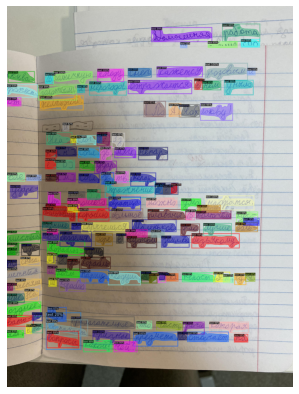

In [ ]:
id_image_selected = 3
example = dataset_dicts_val[id_image_selected]
im = cv2.imread(example["file_name"])
outputs = predictor(im)
plt.figure(figsize=(7,7))
v = Visualizer(im[:, :],
              metadata=val_metadata, 
              scale=0.4 )
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()

В качестве предсказаний для каждого изображения из тестового набора требуется получить бинарную маску, в которой `1` означает, что данный пиксель относится к классу текста.

Давайте на примере одного изображения переведем формат выхода Detectron2 в требуемый формат для соревнования.

`outputs` - результат предсказания модели на данном изображении из предыдущего блока с кодом

In [ ]:
prediction = outputs['instances'].pred_masks.cpu().numpy()

In [ ]:
prediction.shape

(150, 4032, 3024)

В `prediction` находится массив бинарных матриц. Каждая матрица отвечает за отдельную задетектированную маску текста. В нашем случае модель задетектировала 80 текстовых масок. Давайте провизуализируем одну из них.

In [ ]:
prediction[0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

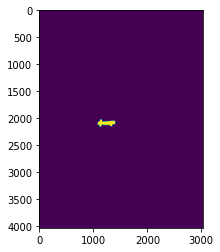

In [ ]:
plt.imshow(prediction[0])

Отлично. Теперь, для того, чтобы получить бинарную маску со всем задетектированным текстом для изображения, нам нужно объединить все маски в одну. Для этого мы просто поэелементно сложим все наши матрицы. Там, где после сложения остались нули - модель не задетектировала никакого текста.

In [ ]:
mask = np.add.reduce(prediction) # Складываем матрицы токенов

In [ ]:
mask = mask > 0

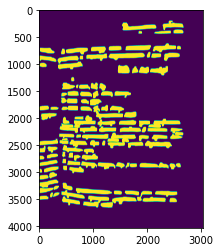

In [ ]:
plt.imshow(mask)

Итак, нам нужно полуить такую маску для каждого изображения из валидационной выборки, а затем посчитать метрику F1-score.

In [ ]:
#Подгрузим аннотации train
with open('data/val/annotations_new.json') as f:
    annotations_val = json.load(f)

In [ ]:
val_images = annotations_val['images']

In [ ]:
val_predictions = {}

In [ ]:
for val_img in tqdm.tqdm_notebook(val_images):
    file_name = val_img['file_name']
    img_path = os.path.join('data/val/images/',file_name)
    im = cv2.imread(img_path)
    outputs = predictor(im)
    prediction = outputs['instances'].pred_masks.cpu().numpy()
    mask = np.add.reduce(prediction)
    mask = mask > 0
    val_predictions[file_name] = mask

Для сохрания предсказаний и загрузки бинарных масок бы будет использовать формат `.npz`. Он позволяет хранить большие массивы в компактном виде. Вот [ссылка](https://numpy.org/doc/stable/reference/generated/numpy.savez_compressed.html) на документацию.

In [ ]:
np.savez_compressed('val_pred.npz',**val_predictions)

In [ ]:
loaded_train = np.load('data/train/binary.npz')

In [ ]:
loaded_val_pred = np.load('val_pred.npz')

Мы используем среднюю метрика F1-score. То есть считаем F1-score для каждого изображения, а затем усредняем результаты. 

Реализация из sklearn работает довольно долго, попэтому мы будем использовать свою.

In [ ]:
def f1_loss(y_true, y_pred):
        
    
    tp = np.sum(y_true & y_pred)
    tn = np.sum(~y_true & ~y_pred)
    fp = np.sum(~y_true & y_pred)
    fn = np.sum(y_true & ~y_pred)
    
    epsilon = 1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1 = 2* precision*recall / ( precision + recall + epsilon)

    return f1 

In [ ]:
f1_scores = []
for key in tqdm.tqdm_notebook(loaded_val_pred.files):
    pred = loaded_val_pred[key].reshape(-1)
    true = loaded_train[key].reshape(-1)
    
    f1_img = f1_loss(true,pred)
    f1_scores.append(f1_img)

  0%|          | 0/104 [00:00<?, ?it/s]

Получившаяся метрика на валидации.

In [ ]:
np.mean(f1_scores)

0.8865043378492855